# GMM gifs and plots

## Setup

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.path as mpath
%matplotlib inline
import matplotlib.animation as animation
from scipy.stats import multivariate_normal
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
def style_plot(ax, grid=True):
    if grid:
        ax.grid(grid, color='w')
        ax.set_axisbelow(True)
    ax.set_facecolor("#F0EDF0")
    
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('w')
    ax.spines['bottom'].set_color('w')

In [3]:
colors_range = [(0, '#008c71'), (1, '#00618c')]
cm = LinearSegmentedColormap.from_list('RdGn', colors_range)
cm_r = LinearSegmentedColormap.from_list('RdGn', [(0, '#00618c'), (1, '#008c71')])

## Gaussian mixture pdf

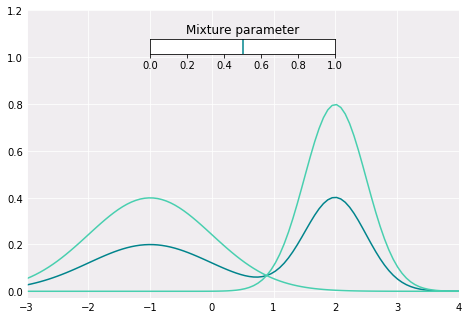

In [4]:
fig, ax = plt.subplots(frameon=False, linewidth=3)

ax.set_position([0, 0, 1, 1])
ax.set_ylim(-0.03, 1.2)
ax.set_xlim(-3, 4)


x = np.linspace(-3, 4, 100)
pdf1 = norm.pdf(x, -1, 1)
pdf2 = norm.pdf(x, 2, 0.5)

style_plot(ax)
line, = ax.plot(x, 0.5 * pdf2 + 0.5 * pdf1, "#00848C")

left_inset_ax = fig.add_axes([2/7., .85, 3/7., .05])
left_inset_ax.set_title('Mixture parameter')
left_inset_ax.set_xlim(0, 1)
left_inset_ax.set_ylim(0, 1)
left_inset_ax.set_yticks([])

parameter, = left_inset_ax.plot([0.5,0.5], [0,1], color="#00848C")
ax.plot(x, pdf1, '#48CFAF')
ax.plot(x, pdf2, '#48CFAF')

In [14]:
def init():  
    line.set_ydata([np.nan] * len(x))
    parameter.set_xdata([np.nan] * 2)
    return line, parameter,

steps_count = 100

def animate(i):
    if i < steps_count / 2:
        j = steps_count / 2 - i
    else:
        j = i - steps_count / 2
    line.set_ydata(pdf1 * j / 50.0 + (1 - j / 50.0) * pdf2)  
    parameter.set_xdata([1 - j / 50.0] * 2)
    return line, parameter, 


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=7, blit=True, save_count=steps_count)

writer = animation.ImageMagickFileWriter()
print("Saving...")
ani.save("gifs/gmm_pdf1.gif")
print("Done")

Saving...


/Users/anastasiakireeva/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py:1218: UserWarning: MovieWriter ffmpeg unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


Done


## GMM sampling

In [6]:
probs = [0.3, 0.15, 0.55]
mu = np.array([[-2, -1], [4, 6], [6, 1]])
sigma = np.array([np.identity(2)] * 3)
N = 100
np.random.seed(12) 
cluster_samples = np.random.choice([0, 1, 2], N, p=probs)
GM_samples = np.array([np.random.multivariate_normal(mu[cluster_samples[i]], 
                                                     sigma[cluster_samples[i]]) for i in range(N)])

(0, 67)

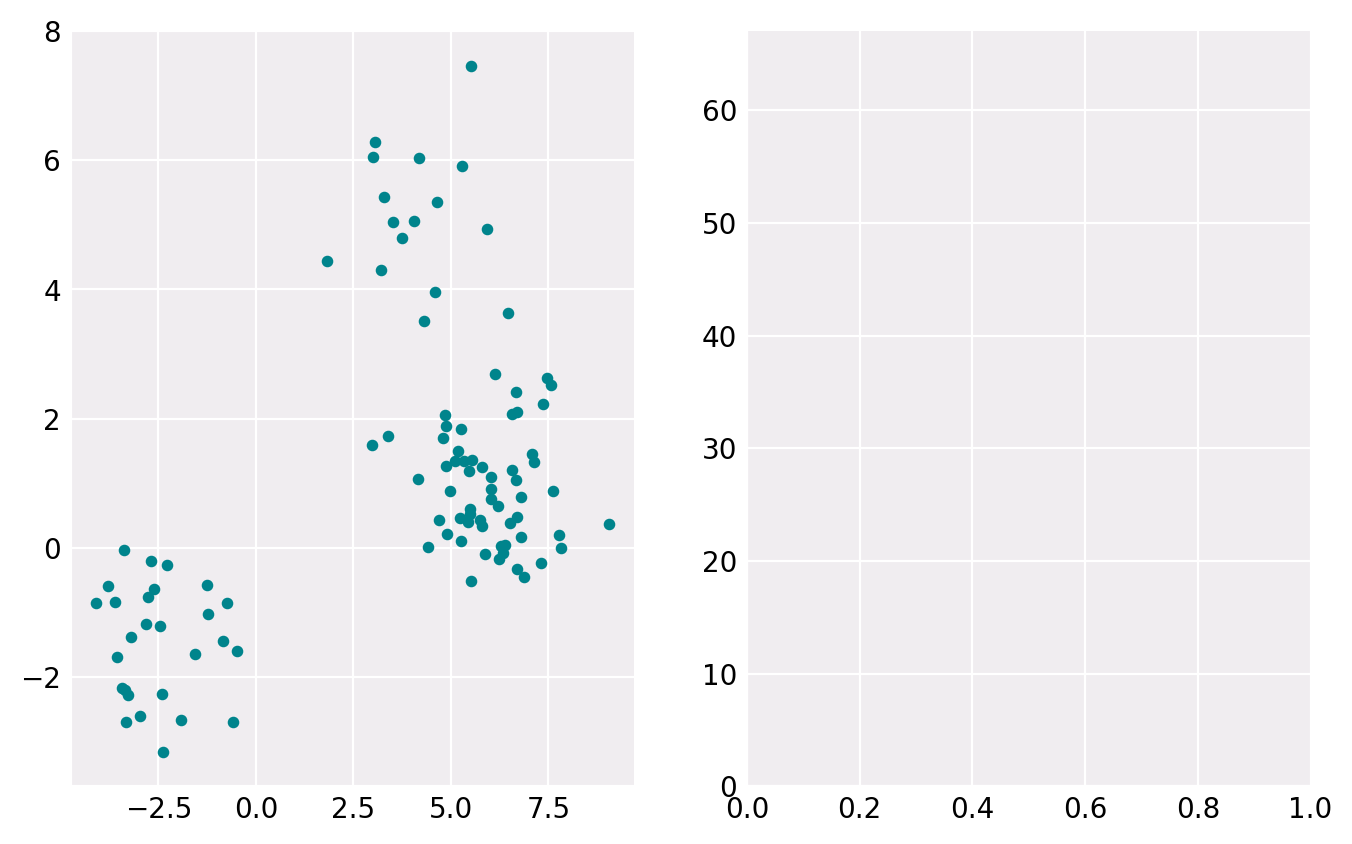

In [7]:
GM_fig, GM_ax = plt.subplots(1, 2, figsize=(8, 5), dpi=200)
style_plot(GM_ax[0])
style_plot(GM_ax[1])
scat_ax = GM_ax[0].scatter(GM_samples[:,0], GM_samples[:,1], color="#00848C", s=10)
GM_ax[1].set_ylim(0, 67)

In [8]:
def init():  
    return scat_ax,

def animate(i):
    scat_ax.set_offsets(GM_samples[:i]) 
    GM_ax[1].clear()
    GM_ax[1].set_ylim(0, 67)
    GM_ax[1].grid(True, color='w')
    GM_ax[1].set_axisbelow(True)
    GM_ax[1].hist(cluster_samples[:i], color="#00848C", bins=[-0.5, 0.5, 1.5, 2.5], rwidth=0.9, alpha=0.75)

    return scat_ax,


ani = animation.FuncAnimation(
    GM_fig, animate, init_func=init, interval=70, blit=True, save_count=N)
print("Saving...")
ani.save("gifs/GMM_sampling.gif", writer=writer)
print("Done")

Saving...
Done


## EM algorithm

In [9]:
def m_step(x, resp):
    n_components = resp.shape[1]
    n_dim = x.shape[1]
    pi = resp.sum(axis=0)[:, np.newaxis] / x.shape[0] 
    mu = np.dot(resp.T, x) / np.sum(resp, axis=0)[:, None]
    sigma = np.zeros((n_components, n_dim, n_dim))
    for i in range(n_components):
        sigma[i] = (resp[:, i] * (x - mu[i]).T).dot(x - mu[i]) / np.sum(resp[:, i])
    return pi, mu, sigma

In [10]:
def e_step(x, pi, mu, sigma):
    resp = np.zeros((x.shape[0], pi.shape[0]))
    for k in range(pi.shape[0]):
        resp[:, k] = pi[k] * multivariate_normal.pdf(x, mu[k], sigma[k])
    resp = resp / np.sum(resp, axis=1)[:, None]
    return resp

In [11]:
probs = [0.4, 0.6]
mu = np.array([[2, 1], [5, 4]])
sigma = np.array([[[1.5, 0.5], [0.5, 1]], [[2, -2], [-2, 3]]])
N = 26
np.random.seed(21) 
cluster_samples = np.random.choice([0, 1], N, p=probs)
GM_samples = np.array([np.random.multivariate_normal(mu[cluster_samples[i]], sigma[cluster_samples[i]]) for i in range(N)])

GM_samples += [2.1, 1.05]

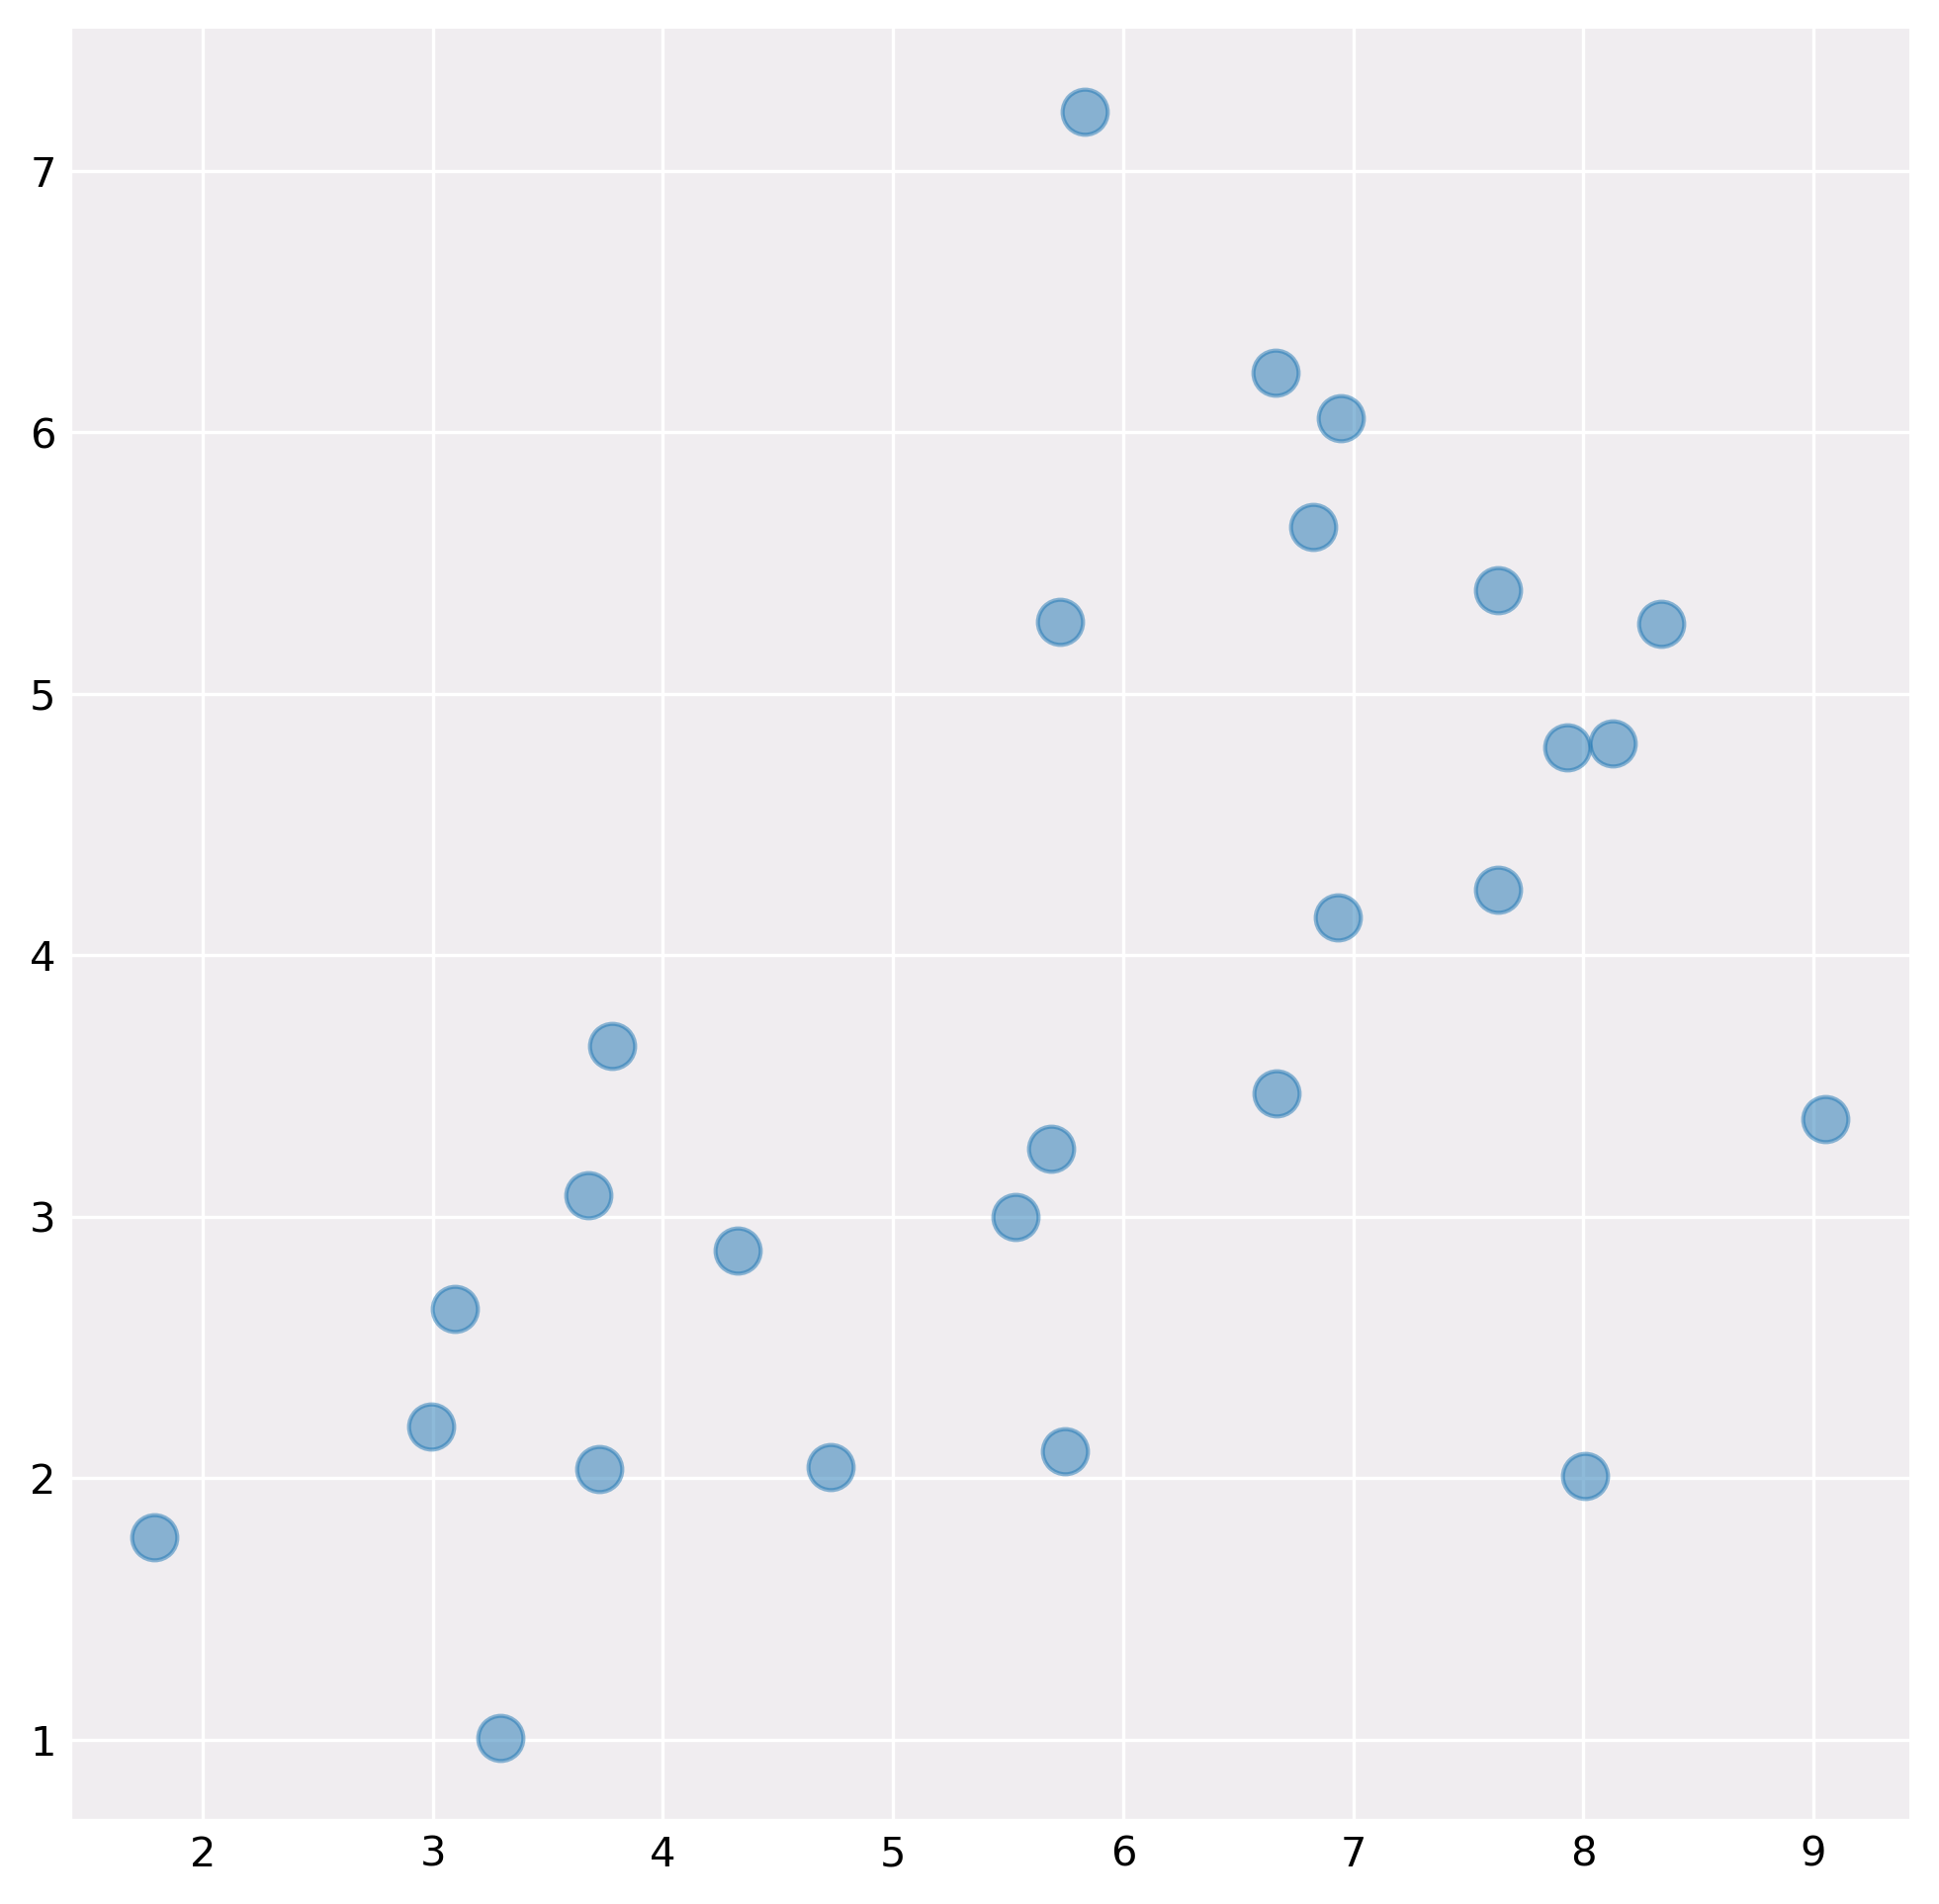

In [12]:
EM_fig, EM_ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)
style_plot(EM_ax)
scat_ax = EM_ax.scatter(GM_samples[:,0], GM_samples[:,1],  s=120, alpha=.5)

In [13]:
x, y = np.mgrid[1:9.7:.05, 0:8:.05]
extent = np.min(x) + 0.3, np.max(x), np.min(y) + 0.3, np.max(y)
pos = np.dstack((x, y))

pi = np.array([0.5, 0.5])
mu = np.array([[3.5,4.5], [7.5,4.5]])
sigma = np.array([np.identity(2)] * 2)
resp = e_step(GM_samples, pi, mu, sigma)
    
def init():  
    #scat_ax = EM_ax.scatter(GM_samples[:,0], GM_samples[:,1], c=resp[:, 0],  s=120, alpha=.5)
    return scat_ax, 


def animate(i):
    global resp, mu, pi, sigma
    
    pi, mu, sigma = m_step(GM_samples, resp)
    resp = e_step(GM_samples, pi, mu, sigma)
    
    EM_ax.clear()
    EM_ax.grid(True, color='w')
    
    rv = multivariate_normal(mu[1], sigma[1])
    EM_ax.contour(x, y, rv.pdf(pos), cmap=cm, linewidths=.5, alpha=.8)
    rv = multivariate_normal(mu[0], sigma[0])
    EM_ax.contour(x, y, rv.pdf(pos), cmap= cm_r, linewidths=.5, alpha=.8)

    EM_ax.scatter(*mu.T)
    scat_ax = EM_ax.scatter(GM_samples[:,0], GM_samples[:,1], c=resp[:, 0],  s=120, alpha=.5)
    
    return scat_ax,


steps_count = 10
ani = animation.FuncAnimation(
    EM_fig, animate, init_func=init, interval=70, blit=True, save_count=steps_count)
writer = animation.ImageMagickFileWriter()


print("Saving...")
ani.save("gifs/GMM_EM.gif", writer=writer)
print("DONE")

Saving...
DONE
